## Import necessary modules

In [1]:
#imports

%matplotlib widget

# python core
import os
import datetime as dt
from collections import defaultdict

# python libraries
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

# themachinethatgoesping modules
from themachinethatgoesping.echosounders import kongsbergall    # Filehandlers for kongsbergall
from themachinethatgoesping.echosounders import index_functions # Helper functions for finding echosounder files
from themachinethatgoesping import echosounders
from themachinethatgoesping import pingprocessing 
from themachinethatgoesping import tools as pingtools

## Open files

In [2]:
# define a list of folder(s) to search for raw data files
folders = []
folders.append("/home/data/turbeams/TURBEAMS_data_crunshing/campaigns/05_TURBEAMS_April_2023/Stations")
folders.append("/home/data/turbeams/TURBEAMS_data_crunshing/campaigns/05_TURBEAMS_April_2023/Transect")

# find all .all/.wcd files and cache file positions
files = index_functions.find_files(folders, [".all","wcd"])
cache_files = index_functions.get_cache_file_paths(files)

# open all files and index
fm = kongsbergall.KongsbergAllFileHandler(files,cache_files)    

Found 288 files
indexing files ⠄ 99% :01s<00m:00s] [Found: 5130471 datagrams in 288 files (25571MB)]                                                 
Initializing navigation ⠄ 96% :02s<00m:00s] [141/144]                   
Initializing ping interface ⠠ 99% :04s<00m:00s] [Done]                                              


In [3]:
print(fm)

KongsbergAllFileHandler
#######################
-
File infos 
-------------               
- Number of loaded .all files: : 144      
- Number of loaded .wcd files: : 144      
- Total file size: :             24.97 GB 

 Detected datagrams 
^^^^^^^^^^^^^^^^^^^^ 
- timestamp_first:  19/04/2023 18:36:51.89 
- timestamp_last:   22/04/2023 02:31:12.19 
- Total:            5130471                
- Datagrams [0x30]: 166                    [PUIDOutput]
- Datagrams [0x31]: 127381                 [PUStatusOutput]
- Datagrams [0x41]: 505522                 [AttitudeDatagram]
- Datagrams [0x43]: 127681                 [ClockDatagram]
- Datagrams [0x47]: 2554                   [SurfaceSoundSpeedDatagram]
- Datagrams [0x49]: 310                    [InstallationParametersStart]
- Datagrams [0x4e]: 210489                 [RawRangeAndAngle]
- Datagrams [0x50]: 510720                 [PositionDatagram]
- Datagrams [0x52]: 105466                 [RuntimeParameters]
- Datagrams [0x55]: 340             

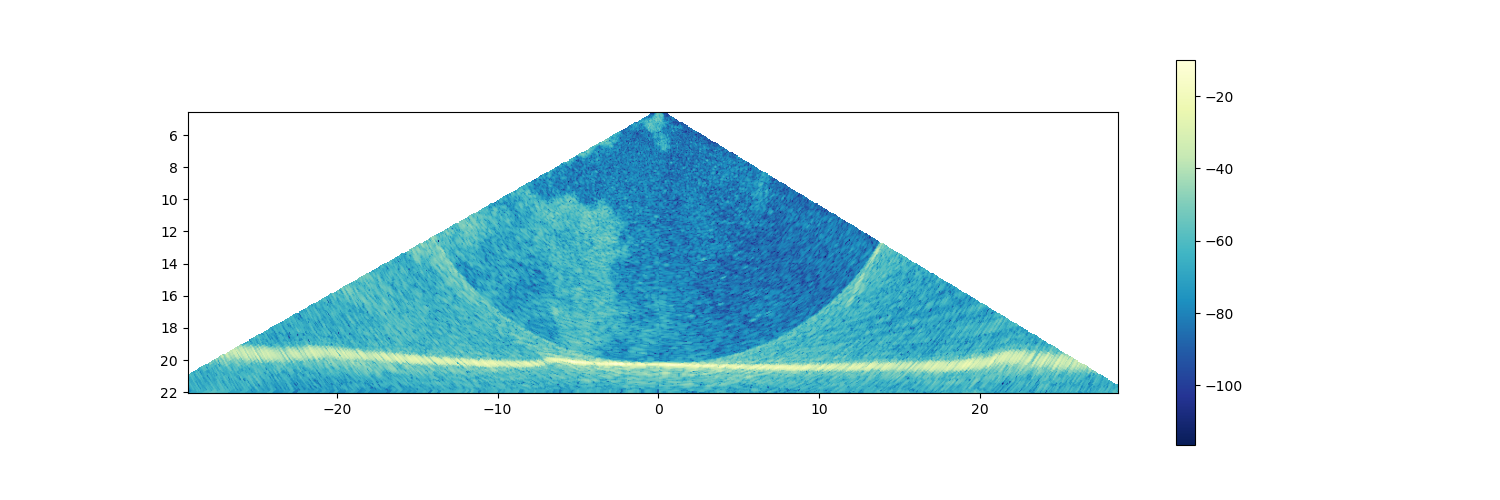

In [7]:
plt.close('wci')
fig = plt.figure('wci')
fig.set_size_inches(15,5)
ax = fig.subplots()

pings = fm.get_pings()
grouped_pings = pingprocessing.group_pings.dual_head(pings)
grouped_ping = grouped_pings[100]

image,extent = pingprocessing.watercolumn.make_image.make_wci_dual_head(grouped_ping,1024, from_bottom_xyz=False)

m = ax.imshow(image.transpose(), extent=extent, cmap='YlGnBu_r', aspect='equal')
fig.colorbar(m)

  0%|          | 0/210675 [00:00<?, ?it/s]

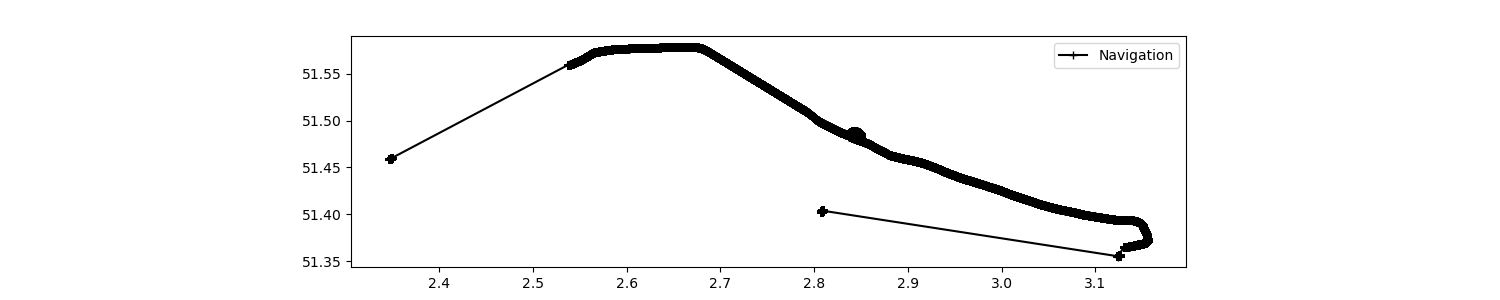

In [4]:
pings = fm.get_pings()

plt.close('navigation')
fig = plt.figure('navigation')
fig.set_size_inches(15,3)
ax = fig.subplots()
ax.set_aspect('equal')
        

#get navigation data
lats = []
lons = []
for ping in tqdm(pings):
    geolocation = ping.get_geolocation()
    lats.append(geolocation.latitude)
    lons.append(geolocation.longitude)

ax.plot(lons,lats, label='Navigation', marker='+', color='black')
ax.legend()    



In [5]:

# select pings from one transducer that contain watercolumn information
filtered_pings = fm.get_pings()('TRX-2004')
filtered_pings = pingprocessing.filter_pings.by_features(filtered_pings, ['watercolumn'])

NameError: name 'EchogramBuilder' is not defined

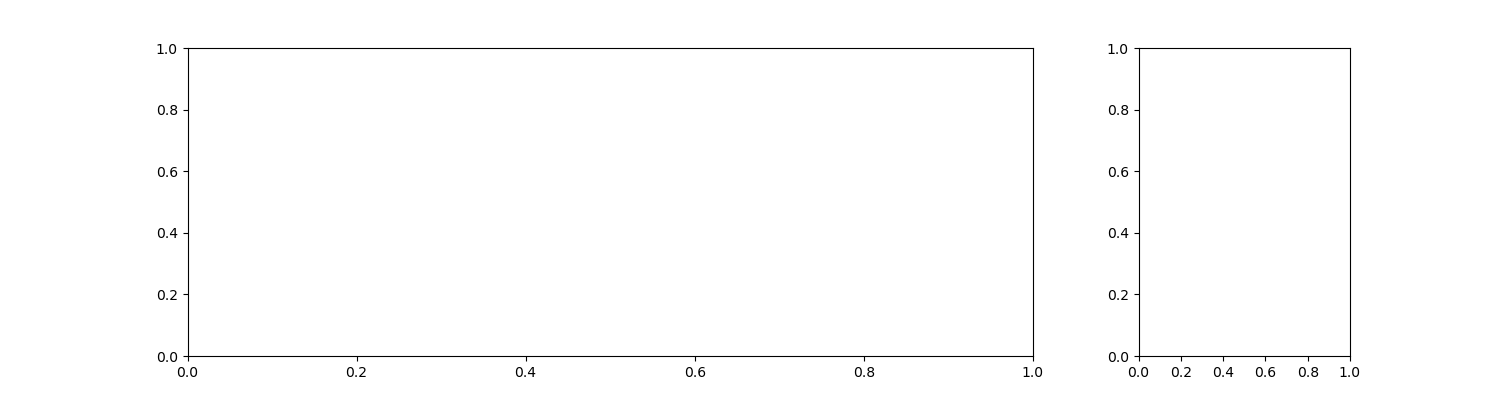

In [6]:
plt.close('echo')
fig = plt.figure('echo')
fig.set_size_inches(15,4)
ax_z,ax_n = fig.subplots(ncols=2,width_ratios=[4,1])


# create selector that only selects 
pss = echosounders.pingtools.PingSampleSelector()
pss.select_beam_range_by_angles(-3.5, 3.5)
echobuilder = EchogramBuilder(filtered_pings, pingsampleselector = pss)

#filter pings 
# - only pings from transducer TRX-2004 with water column data
filtered_pings = fm.get_pings()('TRX-2004') 
filtered_pings = pingprocessing.filter_pings.by_features(filtered_pings, ['watercolumn'])

echo_z = echobuilder.build_echogram(
    max_pings   = 10000,
    min_time = np.nan,
    max_time = np.nan
)

vmin = -90
vmax = -45
fig_z,ax_z = plot_echogram(echo_z, name="full echogram", vmin=vmin, vmax = vmax, ax =ax_z)
plot_navigation_data(pings, 'Navigation: all pings', color='black', ax =ax_n);

In [ ]:
min_time_, max_time_ = mdates.num2date(ax_z.get_xlim())
ylim = ax_z.get_ylim()

echo_zz = echobuilder.build_echogram(
    max_pings   = 10000,
    min_time = min_time_.timestamp(),
    max_time = max_time_.timestamp()
    )

new_pings = pingprocessing.filter_pings.by_time(filtered_pings, min_time_.timestamp(),max_time_.timestamp())

plot_echogram(echo_zz, name="full echogram", ax = ax_z, colorbar=False, vmin=vmin, vmax=vmax)
ax_z.set_xlim(min_time_,max_time_)
ax_z.set_ylim(ylim)
plot_navigation_data(filtered_pings, 'Navigation: all pings', color='black', ax =ax_n);
plot_navigation_data(new_pings, 'Navigation: subgroup pings', color='red', ax =ax_n);

In [7]:
# Plot navigation data
legend = None

def plot_navigation_data(pings, label, ax = None, **kwargs):
    global legend
    if ax is None:
        plt.close('navigation')
        fig = plt.figure('navigation')
        ax = fig.subplots()
        ax.set_aspect('equal')
        

    #get navigation data
    lats = []
    lons = []
    for ping in tqdm(pings):
        geolocation = ping.get_geolocation()
        lats.append(geolocation.latitude)
        lons.append(geolocation.longitude)

    ax.plot(lons,lats, label=label, marker='+',**kwargs)
    if legend is None:
        legend = ax.legend()
    else:
        legend.update_from(ax)
    
    return ax



  0%|          | 0/210675 [00:00<?, ?it/s]

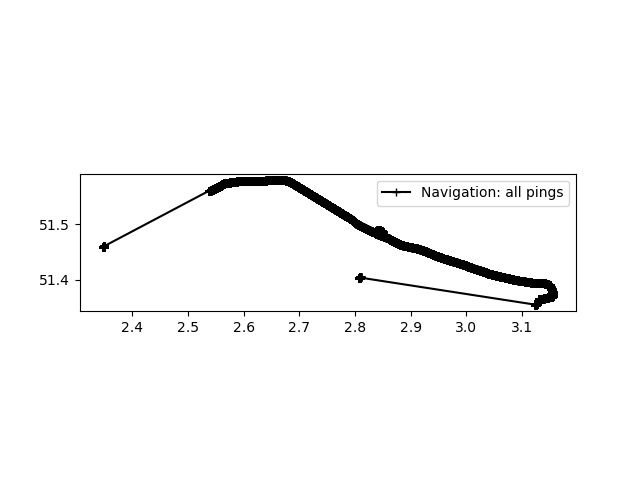

In [8]:
ax = plot_navigation_data(pings, 'Navigation: all pings', color='black')

In [9]:
minlat, maxlat = ax.get_ylim()
minlon, maxlon = ax.get_xlim()

new_pings = []
for ping in tqdm(pings):
    g = ping.get_geolocation()
    
    if minlat <= g.latitude and \
       maxlat >= g.latitude and \
       minlon <= g.longitude and \
       maxlon >= g.longitude:
        new_pings.append(p)

ax = plot_navigation_data(new_pings, 'Navigation: filtered pings', ax=ax, color='blue')

  0%|          | 0/210675 [00:00<?, ?it/s]

NameError: name 'p' is not defined

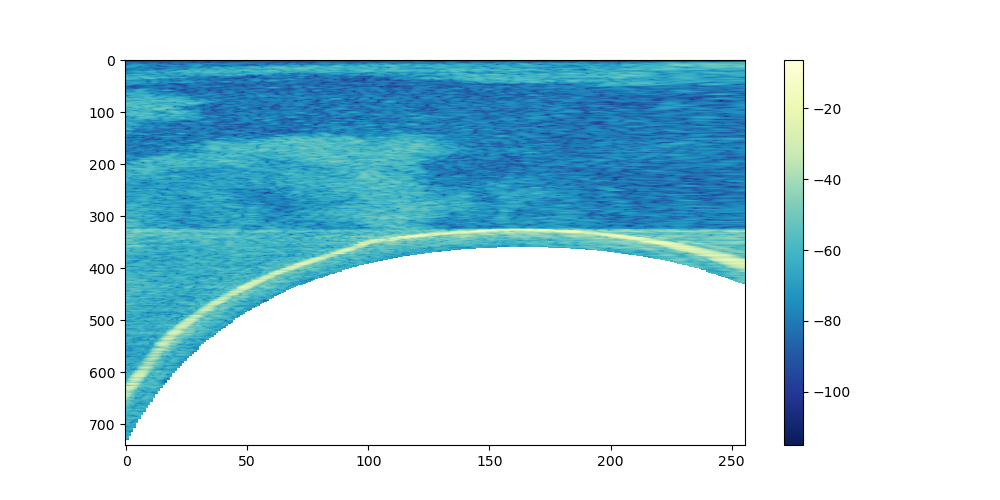

In [17]:
plt.close('wci')
fig = plt.figure('wci')
fig.set_size_inches(10,5)
ax = fig.subplots()

pings = fm.get_pings()
ping = pings[199]

image = ping.watercolumn.get_av()

m = ax.imshow(image.transpose(), cmap='YlGnBu_r', aspect='auto')
fig.colorbar(m)

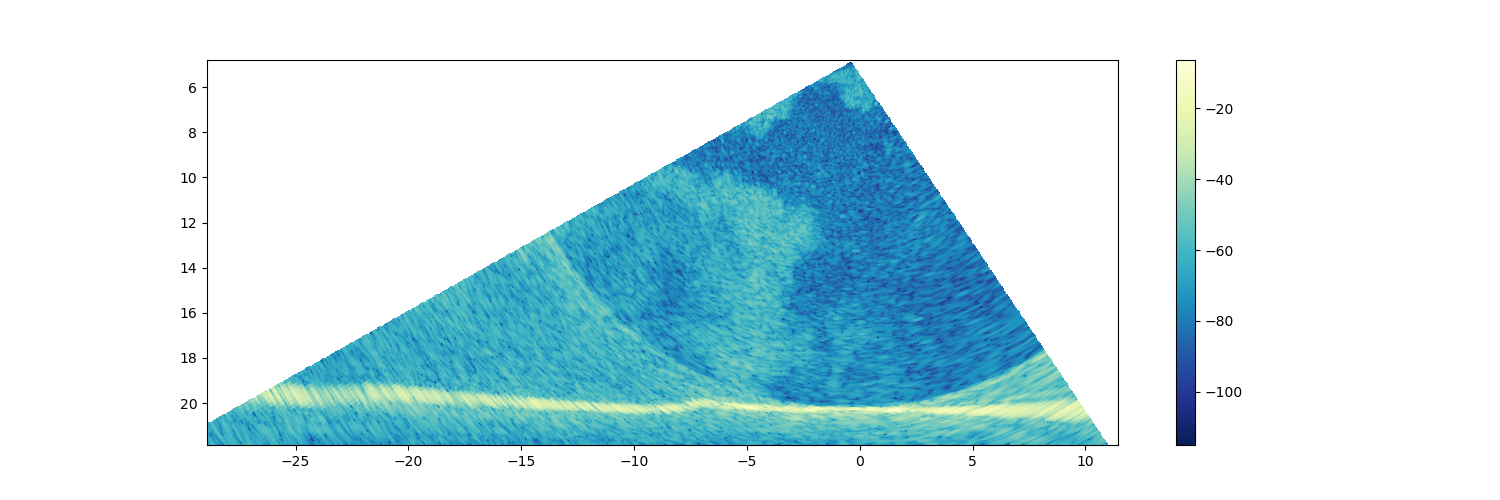

In [16]:
plt.close('wci')
fig = plt.figure('wci')
fig.set_size_inches(15,5)
ax = fig.subplots()

pings = fm.get_pings()
ping = pings[199]

image,extent = pingprocessing.watercolumn.make_image.make_wci(ping,1024, from_bottom_xyz=False)

m = ax.imshow(image.transpose(), extent=extent, cmap='YlGnBu_r', aspect='equal')
fig.colorbar(m)

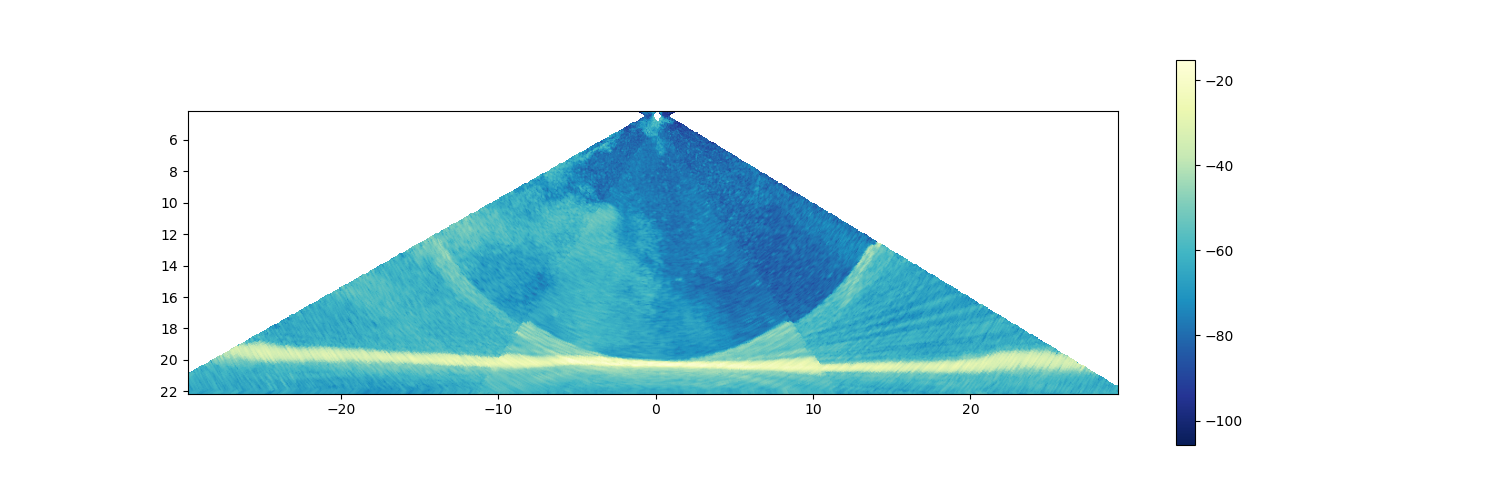

In [14]:
plt.close('wci')
fig = plt.figure('wci')
fig.set_size_inches(15,5)
ax = fig.subplots()


pings = fm.get_pings()

image,extent = pingprocessing.watercolumn.make_image.make_wci_stack(pings[200:210],1024, from_bottom_xyz=False)

m = ax.imshow(image.transpose(), extent=extent, cmap='YlGnBu_r', aspect='equal')
fig.colorbar(m)

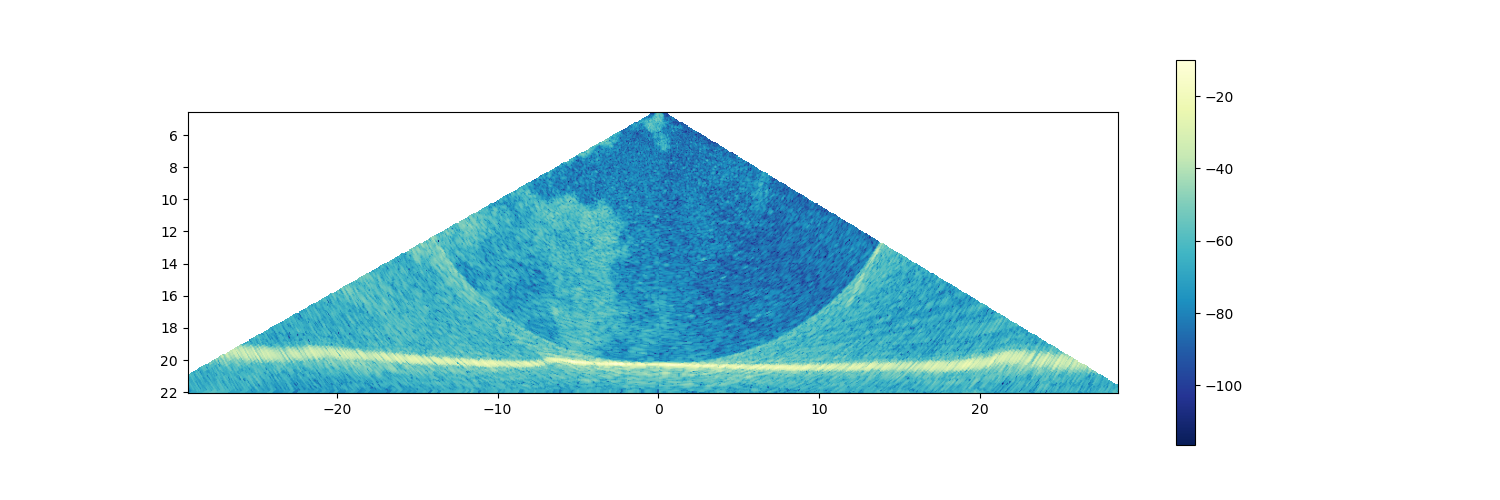

In [12]:
plt.close('wci')
fig = plt.figure('wci')
fig.set_size_inches(15,5)
ax = fig.subplots()

pings = fm.get_pings()
grouped_pings = pingprocessing.group_pings.dual_head(pings)
grouped_ping = grouped_pings[100]

image,extent = pingprocessing.watercolumn.make_image.make_wci_dual_head(grouped_ping,1024, from_bottom_xyz=False)

m = ax.imshow(image.transpose(), extent=extent, cmap='YlGnBu_r', aspect='equal')
fig.colorbar(m)

In [18]:
# Plot navigation data
legend = None

def plot_navigation_data(pings, label, ax = None, **kwargs):
    global legend
    if ax is None:
        plt.close('navigation')
        fig = plt.figure('navigation')
        ax = fig.subplots()
        ax.set_aspect('equal')
        

    #get navigation data
    lats = []
    lons = []
    for ping in tqdm(pings):
        geolocation = ping.get_geolocation()
        lats.append(geolocation.latitude)
        lons.append(geolocation.longitude)

    ax.plot(lons,lats, label=label, marker='+',**kwargs)
    if legend is None:
        legend = ax.legend()
    else:
        legend.update_from(ax)
    
    return ax
    
# helper functions
close_plots = True
def create_figure(name: str, return_ax: bool = True):
    """Helper function to create a figure with a given name that returns the figure and axis
    """
    if close_plots:
        plt.close(name)
    fig = plt.figure(name)
    fig.suptitle = name

    if return_ax:
        return fig, fig.subplots()
    return fig

def set_ax_timeformat(ax, timeformat = "%d-%m-%Y %H:%M:%S"):
    if not hasattr(ax, '__iter__'):
        ax = [ax]
    
    for a in ax:
        a.xaxis.set_major_formatter(mdates.DateFormatter(timeformat))
        a.xaxis.set_major_locator(mdates.AutoDateLocator())
        a.tick_params(axis='x', rotation=30)

class EchogramBuilder:
    def __init__(self, pings, pingsampleselector = echosounders.pingtools.PingSampleSelector()):
        self.pings = np.array(pings)
        self.pss = pingsampleselector

    def build_echogram(
        self,
        max_pings   = 10000, 
        max_samples = None,
        max_image_size = 10000 * 3000,
        min_time = np.nan,
        max_time = np.nan, 
        min_depth = np.nan,
        max_depth = np.nan,
        min_delta_t = np.nan,
        min_delta_t_quantile = 0.05,
        pss = None,
        linear_mean = True,
        use_range = False,
        verbose=True
        ):

        if pss is None:
            pss = self.pss
        
        # build echogram parameters
        echoparam = EchoPingParameters( 
            pings = self.pings, 
            max_pings   = max_pings,
            max_samples = max_samples,
            max_image_size = max_image_size,
            min_time = min_time,
            max_time = max_time, 
            min_depth = min_depth,
            max_depth = max_depth,
            pss = pss,
            linear_mean = linear_mean,
            verbose=verbose)
        self.last_echoparam = echoparam
        
        image, extent = echoparam.build_image(use_datetime = True, use_range = use_range)
        echo = pingprocessing.watercolumn.echograms.EchogramSection(image)
        
        bottom_depth = echoparam.bottom_d
        if use_range:
            heave = echoparam.min_d - echoparam.min_r
            bottom_depth -= heave

        echo.set_bottom_depths(bottom_depth[np.isfinite(bottom_depth)], echoparam.times[np.isfinite(bottom_depth)])

        echo.set_echosounder_depths(echoparam.min_d[np.isfinite(echoparam.min_d)], echoparam.times[np.isfinite(echoparam.min_d)])
        echo.set_ping_times(echoparam.echopingtimes)

        if use_range:
            echo.set_sample_depths(echoparam.ranges)
        else:
            echo.set_sample_depths(echoparam.depths)
        #echo.set_ping_distances
        #echo.set_ping_numbers
        #echo.set_sample_numbers

        return echo


def plot_echogram(self, 
                  ping_axis = 'time', 
                  sample_axis = 'depth',
                  ax = None,
                  fig_size = (15,4),
                  name = 'Echogram',
                  colorbar = True,
                  plot_bottom = True,
                  **kwargs):
    
    image,extent = self.get_echogram(ping_axis=ping_axis, sample_axis=sample_axis)
    
    plot_args = {
    "vmin" : np.nanquantile(image, 0.05),
    "vmax" : np.nanquantile(image, 0.95),
    "aspect" : "auto",
    "cmap" : "YlGnBu_r"
    }
    plot_args.update(kwargs)

    if ax is None:
        fig,ax = create_figure(name)
        fig.set_size_inches(15,4)
        set_ax_timeformat(ax)
        
    mapable = ax.imshow(image.transpose(), extent = extent, **plot_args)

    if plot_bottom and len(echo_z._bottom_depths) > 0:
        times = self.get_ping_times_unixtimes()
        bottom = self.bottom_depth_per_ping_time(times)
        ax.plot(self.get_ping_times_datetimes(), bottom, color='black')

    if colorbar:
        ax.get_figure().colorbar(mapable,ax=ax)

    return ax.get_figure(),ax


class EchoPingParameters:
    def __init__(self, 
                 pings, 
                 max_pings   = 10000, 
                 max_samples = None,
                 max_image_size = 10000 * 3000,
                 min_time = np.nan,
                 max_time = np.nan, 
                 min_depth = np.nan,
                 max_depth = np.nan,
                 min_delta_t = np.nan,
                 min_delta_t_quantile = 0.05,
                 pss = echosounders.pingtools.PingSampleSelector(),
                 linear_mean = True,
                 verbose=True):
        
        echopingtimes, echopingnumbers = self.sample_ping_times(
            pings = pings,
            max_pings = max_pings,
            min_time = min_time,
            max_time = max_time,
            min_delta_t = min_delta_t,
            min_delta_t_quantile = min_delta_t_quantile,
            verbose = verbose)

        if max_samples is None:
            max_samples = int(max_image_size/len(echopingnumbers))
        
        AV = []
        min_r = []
        max_r = []
        res_r = []
        min_d = []
        max_d = []
        bottom_d = []
        nrs = {}
        times = []
        
        nroff=0
        
        for NR,nr in enumerate(tqdm(np.unique(echopingnumbers))):
            if nr == -1:
                nroff += 1
                continue
                
            nrs[nr] = NR - nroff
            
            ping = pings[nr]
            
            sel = pss.apply_selection(ping.watercolumn)
            c = ping.watercolumn.get_sound_speed_at_transducer()
            z = ping.get_geolocation().z
            res_r.append(ping.watercolumn.get_sample_interval()*c*0.5)
            min_r.append(np.max(ping.watercolumn.get_first_sample_offset_per_beam()[sel.get_beam_numbers()])*res_r[-1])
            max_r.append(np.max(ping.watercolumn.get_number_of_samples_per_beam(sel))*res_r[-1] + min_r[-1])
            min_d.append(z + min_r[-1])
            max_d.append(z + max_r[-1])
            times.append(ping.get_timestamp())
        
            if ping.has_bottom():
                sel_bottom = pss.apply_selection(ping.bottom)
                #bd = np.nanmin(p.bottom.get_xyz(sel_bottom).z) + p.get_geolocation().z
                # this is incorrect
                bd = np.nanmin(ping.bottom.get_xyz(sel).z) + ping.get_geolocation().z
        
                bottom_d.append(bd)
            else:
                bottom_d.append(np.nan)
            
            av = ping.watercolumn.get_av(sel)
            if av.shape[0] == 1:
                av = av[0]
            else:
                if linear_mean:
                    av = np.power(10,av*0.1)
        
                av = np.nanmean(av,axis=0)
        
                if linear_mean:
                    av = 10*np.log10(av)
        
            AV.append(av)

        self.AV    = AV
        self.min_d = np.array(min_d)
        self.max_d = np.array(max_d)
        self.res_r = np.array(res_r)
        self.min_r = np.array(min_r)
        self.max_r = np.array(max_r)
        self.bottom_d = np.array(bottom_d)
        self.times=np.array(times)
        self.echopingtimes = np.array(echopingtimes)
        self.echopingtimestep = self.echopingtimes[1] - self.echopingtimes[0]
        self.echopingnumbers = np.array(echopingnumbers)
        self.nrs = nrs
        self.depths = self.sample_image_depths(self.min_d, self.max_d, self.res_r, min_depth, max_depth, max_samples)
        self.ranges = self.sample_image_depths(self.min_r, self.max_r, self.res_r, min_depth, max_depth, max_samples)
        self.range_step = self.depths[1] - self.depths[0]

    @staticmethod
    def sample_ping_times(pings, max_pings=10000, min_time = np.nan, max_time = np.nan, min_delta_t = np.nan, min_delta_t_quantile = 0.05, verbose=True):
        
        min_time = np.nanmax([pings[0].get_timestamp(), min_time])
        max_time = np.nanmin([pings[-1].get_timestamp(), max_time])
        
        if verbose:
            print(f'- Min time  : {dt.datetime.fromtimestamp(min_time,dt.UTC)}\n- Max time  : {dt.datetime.fromtimestamp(max_time,dt.UTC)}\n- Diff {max_time-min_time}')
        
        # filter pings by time range and find delta t per transducer
        pings_filtered = pingprocessing.filter_pings.by_time(pings, min_time, max_time)
        pings_per_channel = pingprocessing.split_pings.by_channel_id(pings_filtered)
        
        ping_delta_t = []
        for cid, P in pings_per_channel.items():
            for i in range(1,len(P)):
                ping_delta_t.append(P[i].get_timestamp() - P[i-1].get_timestamp())
        
        min_delta_t = np.nanmax([np.nanquantile(ping_delta_t,min_delta_t_quantile), min_delta_t])
                
        # get ping_times
        ping_times = np.array([p.get_timestamp() for p in tqdm(pings, delay=2)])
        ping_numbers = np.array(list(range(len(pings))))
        
        echo_times = np.linspace(min_time,max_time,max_pings)
        delta_t = (echo_times[1]-echo_times[0])
        if delta_t < min_delta_t:
            delta_t = min_delta_t
            echo_times = np.arange(min_time, max_time + delta_t, delta_t)
        
        
        # get nearest neighbor for echo_times
        interplator = pingtools.vectorinterpolators.NearestInterpolator(ping_times,ping_numbers)
        echopingnumbers = np.array(interplator(echo_times)).astype(int)
        echopingtimes = ping_times[echopingnumbers]
        
        # exclude all times where the time difference is larger than delta_t/2
        echopingdiffs = np.abs(echo_times - echopingtimes)
        excl = np.argwhere(echopingdiffs > delta_t * 0.5)
        
        echopingtimes[excl]   = np.nan
        echopingnumbers[excl] = -1
        
        # remove duplicate numbers
        u, c = np.unique(echopingnumbers, return_counts=True)
        C = int(np.quantile(c,0.75,method='linear'))
    
        if C > 1:
            max_pings = int(max_pings/C)
    
            if max_pings > 10:
                print("MAX PINGS:", max_pings, C)
                return EchoPingParameters.sample_ping_times(
                      pings = pings,
                      max_pings = max_pings,
                      min_time = min_time,
                      max_time = max_time,
                      verbose = verbose)
    
        return echo_times, echopingnumbers

    @staticmethod
    def sample_image_depths(min_d, max_d, res_r, min_depth, max_depth, max_samples = 5000):
        # filter 
        if min_depth is None: min_depth = np.nanquantile(min_d,0.25)/1.5        
        if max_depth is None: max_depth = np.nanquantile(max_d,0.75)*1.5
        min_resolution = np.nanquantile(res_r,0.25)/1.5
                
        res = np.nanmax([np.nanmin(res_r), min_resolution])
        mind = np.nanmax([np.nanmin(min_d), min_depth])
        maxd = np.nanmin([np.nanmax(max_d), max_depth])
        
        depths = np.arange(mind, maxd + res, res)
        
        if len(depths) > max_samples:
            depths = np.linspace(mind, maxd, max_samples)
        
        return depths

    def build_image(self, use_range = False, use_datetime = True):
        
        i_echo = []
        i_av   = []

        if use_range:
            min_d = self.min_r
            max_d = self.max_r
            depths = self.ranges
        else:
            min_d = self.min_d
            max_d = self.max_d
            depths = self.depths

        image = np.empty((len(self.echopingnumbers),len(depths)))
        image.fill(np.nan)
        
        for i in tqdm(range(len(self.AV))):
            interpolator = pingtools.vectorinterpolators.LinearInterpolator([min_d[i],max_d[i]],[0,len(self.AV[i])])
            index_av = np.round(interpolator(depths)).astype(int)
            index_echo = np.array(range(len(depths)))
        
            index_echo = index_echo[index_av >= 0]
            index_av = index_av[index_av >= 0]
            
            i_echo.append(index_echo[index_av < len(self.AV[i])])
            i_av.append(index_av[index_av < len(self.AV[i])])
        
        for i,nr in enumerate(tqdm(self.echopingnumbers)):
            if nr == -1:
                continue
            NR = self.nrs[nr]
            
            index_echo = i_echo[NR]
            index_av = i_av[NR]
            image[i][index_echo] = self.AV[NR][index_av]

        extent = [
            self.echopingtimes[0]  - self.echopingtimestep*0.5,
            self.echopingtimes[-1] + self.echopingtimestep*0.5,
            depths[-1] + self.range_step*0.5,
            depths[0]  - self.range_step*0.5
        ]

        if use_datetime:
            extent[0] = dt.datetime.fromtimestamp(extent[0], dt.UTC)
            extent[1] = dt.datetime.fromtimestamp(extent[1], dt.UTC)
        
        return image, extent
        



In [25]:

# select pings from one transducer that contain watercolumn information
filtered_pings = fm.get_pings()('TRX-2004')
filtered_pings = pingprocessing.filter_pings.by_features(filtered_pings, ['watercolumn'])
filtered_pings = pingprocessing.filter_pings.by_time(filtered_pings,min_time_.timestamp(),max_time_.timestamp())

- Min time  : 2023-04-21 09:18:11.552000+00:00
- Max time  : 2023-04-21 18:30:26.593000+00:00
- Diff 33135.040999889374


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

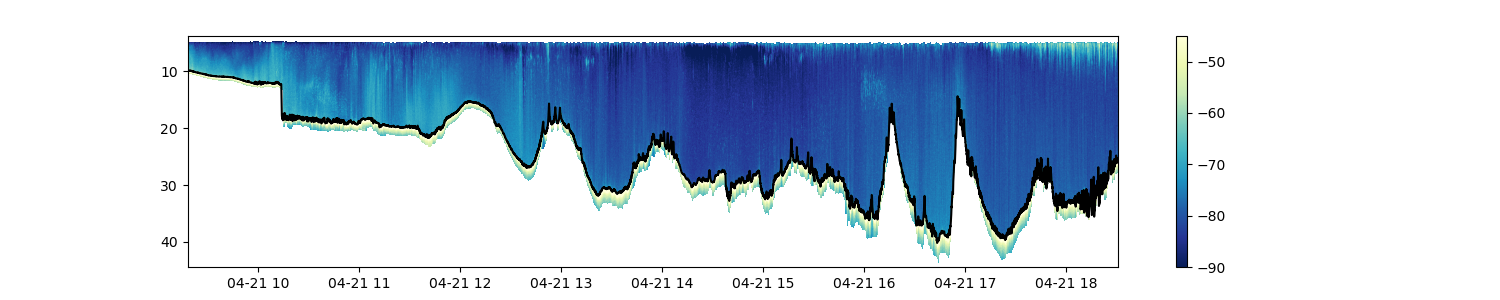

In [38]:
plt.close('echo')
fig = plt.figure('echo')
fig.set_size_inches(15,3)
ax_z = fig.subplots()

# create selector that only selects 
pss = echosounders.pingtools.PingSampleSelector()
pss.select_beam_range_by_angles(-3.5, 3.5)
echobuilder = EchogramBuilder(filtered_pings, pingsampleselector = pss)

echo_z = echobuilder.build_echogram(
    max_pings   = 10000,
    min_time = np.nan,
    max_time = np.nan
)

vmin = -90
vmax = -45
fig_z,ax_z = plot_echogram(echo_z, name="full echogram", vmin=vmin, vmax = vmax, ax =ax_z)

In [39]:
min_time_, max_time_ = mdates.num2date(ax_z.get_xlim())
ylim = ax_z.get_ylim()

echo_zz = echobuilder.build_echogram(
    max_pings   = 10000,
    min_time = min_time_.timestamp(),
    max_time = max_time_.timestamp()
    )

new_pings = pingprocessing.filter_pings.by_time(filtered_pings, min_time_.timestamp(),max_time_.timestamp())

plot_echogram(echo_zz, name="full echogram", ax = ax_z, colorbar=False, vmin=vmin, vmax=vmax)

- Min time  : 2023-04-21 09:59:47.149382+00:00
- Max time  : 2023-04-21 12:16:25.625797+00:00
- Diff 8198.4764149189


  0%|          | 0/6755 [00:00<?, ?it/s]

  0%|          | 0/6754 [00:00<?, ?it/s]

  0%|          | 0/6772 [00:00<?, ?it/s]

(<Figure size 1636.36x327.273 with 2 Axes>, <Axes: >)

- Min time  : 2023-04-21 09:18:11.552000+00:00
- Max time  : 2023-04-21 18:30:26.593000+00:00
- Diff 33135.040999889374


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

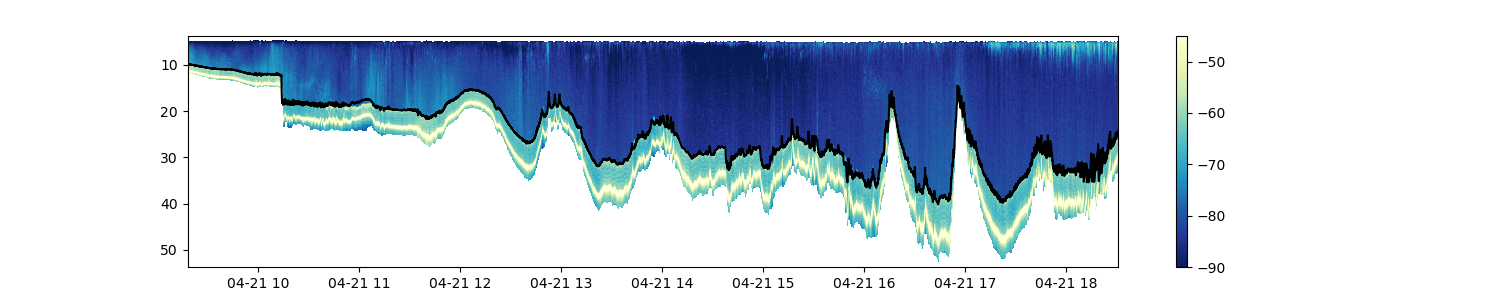

In [47]:
plt.close('echo')
fig = plt.figure('echo')
fig.set_size_inches(15,3)
ax_zz = fig.subplots()

# create selector that only selects 
pss = echosounders.pingtools.PingSampleSelector()
pss.select_beam_range_by_angles(35, 36)
echobuilder = EchogramBuilder(filtered_pings, pingsampleselector = pss)

echo_zz = echobuilder.build_echogram(
    max_pings   = 10000,
    min_time = np.nan,
    max_time = np.nan
)

vmin = -90
vmax = -45
fig_z,ax_z = plot_echogram(echo_zz, name="full echogram", vmin=vmin, vmax = vmax, ax =ax_zz)